In [46]:
import pandas as pd
import numpy as np

# import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [31]:
## load dataset
churnData = pd.read_csv('files_for_lab/customer_churn.csv') # this file is in files_for_lab folder
churnData.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [32]:
## prepare variables
X = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
y = (churnData.Churn == 'Yes').astype(int)

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   SeniorCitizen   7043 non-null   int64  
 2   MonthlyCharges  7043 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 165.2 KB


In [34]:
transformer = StandardScaler().fit(X)
scaled_x = transformer.transform(X)

In [35]:
scaled_x

array([[-1.27744458, -0.43991649, -1.16032292],
       [ 0.06632742, -0.43991649, -0.25962894],
       [-1.23672422, -0.43991649, -0.36266036],
       ...,
       [-0.87024095, -0.43991649, -1.1686319 ],
       [-1.15528349,  2.27315869,  0.32033821],
       [ 1.36937906, -0.43991649,  1.35896134]])

## Modeling before sampling, with imbalanced target, including model validation with train-test-split

In [36]:
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

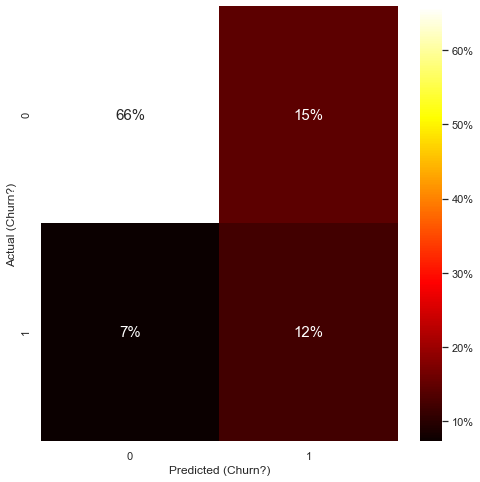

In [74]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, random_state=100)

# instantiating and training of a LogisticRegression model
model = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X_train, y_train)

# creating predictions based on our trained model
y_pred=model.predict(X_test)

# calculating confusion matrix
cnfmat = confusion_matrix(y_pred, y_test)

# creating a Dataframe out of our confusion matrix. Makes it more comfortable to plot in seaborn
df_cm = pd.DataFrame(cnfmat, columns=np.unique(y_test), in
                     dex = np.unique(y_test))

# assinging column and index names to our df
df_cm.index.name = 'Actual (Churn?)'
df_cm.columns.name = 'Predicted (Churn?)'

# set the fontsize for my plot
sns.set(font_scale=1)

# this funcformatter is necessary to create a custom function which formats our values as % later
from matplotlib.ticker import FuncFormatter
fmt = lambda x,pos: '{:.0%}'.format(x)

# set plot size
fig, ax = plt.subplots(figsize=(8,8))

# plot the heatmap for our confusion matrix
sns.heatmap(df_cm/df_cm.sum().sum(),  # plot the number of values as percentage of all values in the confusion matrix
            annot=True,
            fmt='.0%',
            cmap='hot',
            annot_kws={"size":15},
            cbar_kws={'format': FuncFormatter(fmt)}
           );


Observation: It's evident that our model is way better in predicting the `Churn=False` customers correctly than the ones that have churned - because of the heavy misbalance within the target variable of `5174` (Did not churn) to `1869` (have churned)

In [65]:
model.score(scaled_x, y)

0.7905721993468693

# applying SMOTE to get rid of imbalance - (oversample the minority class of the target label)

In [39]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(scaled_x, y)
y_sm.value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

### Model again and plot the confusion matrix (same code like above)

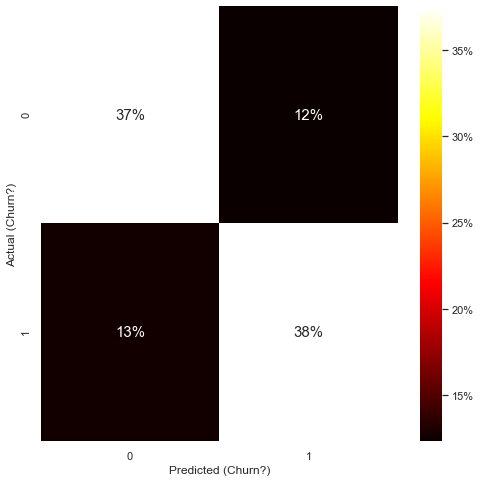

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)

model = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X_train, y_train)

y_pred=model.predict(X_test)
cnfmat = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(cnfmat, columns=np.unique(y_test), index = np.unique(y_test))


df_cm.index.name = 'Actual (Churn?)'
df_cm.columns.name = 'Predicted (Churn?)'

sns.set(font_scale=1)

from matplotlib.ticker import FuncFormatter
fmt = lambda x,pos: '{:.0%}'.format(x)

# set plot size
fig, ax = plt.subplots(figsize=(8,8))

# plot the heatmap
sns.heatmap(df_cm/df_cm.sum().sum(),  # plot the number of values as percentage of all values in the confusion matrix
            annot=True,
            fmt='.0%',
            cmap='hot',
            annot_kws={"size":15},
            cbar_kws={'format': FuncFormatter(fmt)}
           );

Observation
* the quality of correct predictions (true positives, true negatives) got way better after SMOTE and is now balanced. Still, the numbers of false negatives and false positives are fairly high

# Applying TomekLinks to downsample the majority class of the label

In [77]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_sample(scaled_x, y)
y_tl.value_counts()

0    4694
1    1869
Name: Churn, dtype: int64

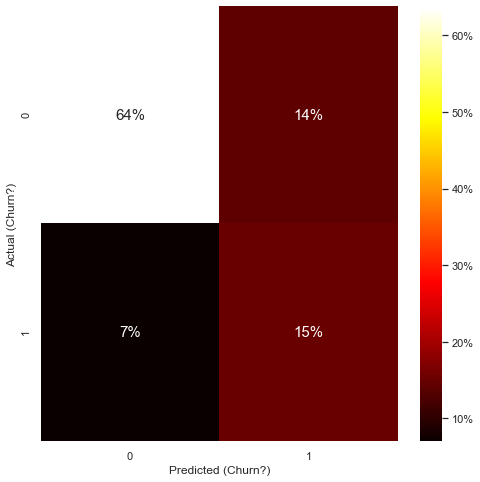

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=100)

model = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X_train, y_train)

y_pred=model.predict(X_test)
cnfmat = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(cnfmat, columns=np.unique(y_test), index = np.unique(y_test))


df_cm.index.name = 'Actual (Churn?)'
df_cm.columns.name = 'Predicted (Churn?)'

sns.set(font_scale=1)

from matplotlib.ticker import FuncFormatter
fmt = lambda x,pos: '{:.0%}'.format(x)

# set plot size
fig, ax = plt.subplots(figsize=(8,8))

# plot the heatmap
sns.heatmap(df_cm/df_cm.sum().sum(),  # plot the number of values as percentage of all values in the confusion matrix
            annot=True,
            fmt='.0%',
            cmap='hot',
            annot_kws={"size":15},
            cbar_kws={'format': FuncFormatter(fmt)}
           );

Observation:
* this result is only a tiny bit better than the one with the unsampled data. This is quite obvious, if we look at how TomekLinks work: It tries to find pairs of datapoints that are similar regarding their features (or in math terms: which are **nearest neighbors in the feature space**, but have opposing values in their label. Then it drops the one belonging to the majority class. In some datasets, when only TomekLinks is applied, there simply cannot be found enough pairs to bring the number of majority class rows down to the number of the minority
* if you're unsure which method to use then, give [this article](https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/) a read. In practice it was shown that combining several sampling techniques yields the bet result 